# Notebook to generate attention versus performance plots.

This notebook requires the processed behavior data for the triangle task, saved
in `../../../cache/behavior/triangle.csv`. This can be downloaded from the OSF
repo or can be generated by running the script
`../../../behavior_processing/run_cache_data.py`.

This notebook also requires the modeling results data, saved in
`../../cache/phys_modeling_logs/main`. This can be downloaded from the OSF
repo or can be generated by training the models yourself.

In [1]:
"""Imports."""

import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.stats import pearsonr

import sys
sys.path.append('../../../behavior_processing')
import load_triangle_data

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [2]:
"""Constants."""

MODEL_NAME = "triangle_gain"
# MODEL_NAME = "triangle_switching"
# MODEL_NAME = "triangle_slot_partition"

In [ ]:
"""Load results."""

np.random.seed(0)  # For reproducibility
MODEL_CACHE_DIR = Path("../../../cache/modeling/main") / MODEL_NAME

# Load behavior data
df_behavior = load_triangle_data.load_data()

if "gain" in MODEL_NAME:
    WRITE_DIR = Path('./plots')
else:
    WRITE_DIR = Path('../../supp_fig_attention_behavior/plots')

# Make attention dataframe
df_attn = {
    "subject": [],
    "session": [],
    "trial_num": [],
    "seed": [],
    "num_neurons": [],
    "num_objects": [],
    "condition_locations": [],
    "condition_identities": [],
    "Performance": [],
    "Reaction time": [],
    "Target location": [],
    "Target identity": [],
    "Target attention": [],
    "Response location": [],
    "Response attention": [],
}
for subject_dir in MODEL_CACHE_DIR.iterdir():
    subject = subject_dir.name
    if subject.startswith("."):
        continue
    for session_dir in subject_dir.iterdir():
        session = session_dir.name
        if session.startswith("."):
            continue

        # Get behavior corresponding to this session
        df_behavior_session = df_behavior[
            (df_behavior["subject"] == subject) &
            (df_behavior["session"] == session)
        ]
        for seed_dir in session_dir.iterdir():
            seed = seed_dir.name
            if seed.startswith("."):
                continue

            # Load attention
            model_dir = MODEL_CACHE_DIR / subject / session / seed
            stop_step_dir = model_dir / "stop_step"
            attention_path = stop_step_dir / "model_cache" / "attention.npy"
            attention = np.load(attention_path)
            if MODEL_NAME == "triangle_slot_partition":
                # attention = attention[:, 0]
                attention = np.sum(attention, axis=1)
            trial_num = np.load(stop_step_dir / "dataset_cache" / "trial_num.npy")
            train_metrics = json.load(open(model_dir / "train_metrics.json"))
            num_neurons = train_metrics[0]["num_neurons"]

            # Create behavior dataframe for these trials
            df_behavior_seed = df_behavior_session[df_behavior_session["trial_num"].isin(trial_num)].copy().reset_index(drop=True)
            if not np.array_equal(df_behavior_seed["trial_num"].values, trial_num):
                raise ValueError("Mismatched trial numbers")
            
            for row_index, row in df_behavior_seed.iterrows():
                locations = [row[f"object_{i}_location"] for i in range(3)]
                locations_finite = [int(loc) for loc in locations if not np.isnan(loc)]
                num_objects = len(locations_finite)
                attentions = attention[row_index]
                identities = [row[f"object_{i}_id"] for i, loc in enumerate(locations) if not np.isnan(loc)]

                # Argsort locations
                locations_argsort = np.argsort(locations_finite)
                condition_locations = tuple([locations_finite[i] for i in locations_argsort])
                condition_identities = tuple([identities[i] for i in locations_argsort])

                # Get target information
                target_index = row["target_object_index"]
                target_location = int(locations[target_index])
                target_identity = row[f"object_{target_index}_id"]
                target_attention = attentions[target_index]

                # Get response information
                response_location = row["response_location"]
                if np.isnan(response_location) or int(response_location) not in locations_finite:
                    response_attention = np.nan
                else:
                    response_index = locations_finite.index(response_location)
                    response_attention = attentions[response_index]

                # Update data
                df_attn["subject"].append(row["subject"])
                df_attn["session"].append(row["session"])
                df_attn["trial_num"].append(int(row["trial_num"]))
                df_attn["seed"].append(int(seed))
                df_attn["num_neurons"].append(num_neurons)
                df_attn["Performance"].append(row["correct"])
                df_attn["Reaction time"].append(1000 * row["reaction_time"])
                df_attn["num_objects"].append(num_objects)
                df_attn["condition_locations"].append(condition_locations)
                df_attn["condition_identities"].append(condition_identities)
                df_attn["Target location"].append(target_location)
                df_attn["Target identity"].append(target_identity)
                df_attn["Target attention"].append(target_attention)
                df_attn["Response attention"].append(response_attention)
                df_attn["Response location"].append(response_location)
df_attn = pd.DataFrame(df_attn)
df_attn["subject_session"] = df_attn["subject"] + "_" + df_attn["session"]
df_attn["subject_session_seed"] = df_attn["subject"] + "_" + df_attn["session"] + "_" + df_attn["seed"].astype(str)

# Compute performance dataframe with residuals
df_attn_performance = df_attn[
    (~df_attn["Target attention"].isna())
    & (df_attn["num_objects"] == 3)
].copy()
for subject_session_seed in df_attn_performance["subject_session_seed"].unique():
    df_session = df_attn_performance[df_attn_performance["subject_session_seed"] == subject_session_seed]
    for response_location in df_session["Response location"].unique():
        df_location = df_session[df_session["Target location"] == target_location]
        for condition_id in df_location["condition_identities"].unique():
            df_identity = df_location[df_location["condition_identities"] == condition_id]

            # Compute residuals
            performance_mean = df_identity["Performance"].mean()
            attention_mean = df_identity["Target attention"].mean()
            residual_performance = df_identity["Performance"] - performance_mean
            residual_attention = df_identity["Target attention"] - attention_mean
            residual_attention = np.array(residual_attention)
            residual_attention = (residual_attention - np.mean(residual_attention)) / np.std(residual_attention)
            
            # Add residuals to dataframe
            df_attn_performance.loc[df_identity.index, "Residual performance"] = residual_performance
            df_attn_performance.loc[df_identity.index, "Residual target attention"] = residual_attention

# Compute reaction time dataframe with residuals
df_attn_reaction_time = df_attn[
    (df_attn["Performance"])
    & (~df_attn["Target attention"].isna())
    & (df_attn["num_objects"] == 3)
].copy()
for subject_session_seed in df_attn_reaction_time["subject_session_seed"].unique():
    df_session = df_attn_reaction_time[df_attn_reaction_time["subject_session_seed"] == subject_session_seed]
    for target_location in df_session["Target location"].unique():
        df_location = df_session[df_session["Target location"] == target_location]
        for condition_id in df_location["condition_identities"].unique():
            df_condition = df_location[df_location["condition_identities"] == condition_id]
            for target_identity in df_condition["Target identity"].unique():
                df_identity = df_condition[df_condition["Target identity"] == target_identity]

                # Compute residuals
                reaction_time_mean = df_identity["Reaction time"].mean()
                attention_mean = df_identity["Target attention"].mean()
                residual_reaction_time = df_identity["Reaction time"] - reaction_time_mean
                residual_attention = df_identity["Target attention"] - attention_mean
                residual_attention = np.array(residual_attention)
                residual_attention = (residual_attention - np.mean(residual_attention)) / np.std(residual_attention)
                
                # Add residuals to dataframe
                df_attn_reaction_time.loc[df_identity.index, "Residual target attention"] = residual_attention
                df_attn_reaction_time.loc[df_identity.index, "Residual reaction time"] = residual_reaction_time

<>:79: SyntaxWarning: invalid escape sequence '\p'
<>:79: SyntaxWarning: invalid escape sequence '\p'
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_8686/4121070267.py:79: SyntaxWarning: invalid escape sequence '\p'
  f"$R={corr:.2f} \pm {corr_sem:.2f}$",


Subject: Perle, R = 0.346434, corr_sem: 0.04237649559306766, p-value: 6.942215692613157e-10, num_points: 300
Subject: Elgar, R = 0.261972, corr_sem: 0.04115591904159105, p-value: 5.0863276591972956e-08, num_points: 420


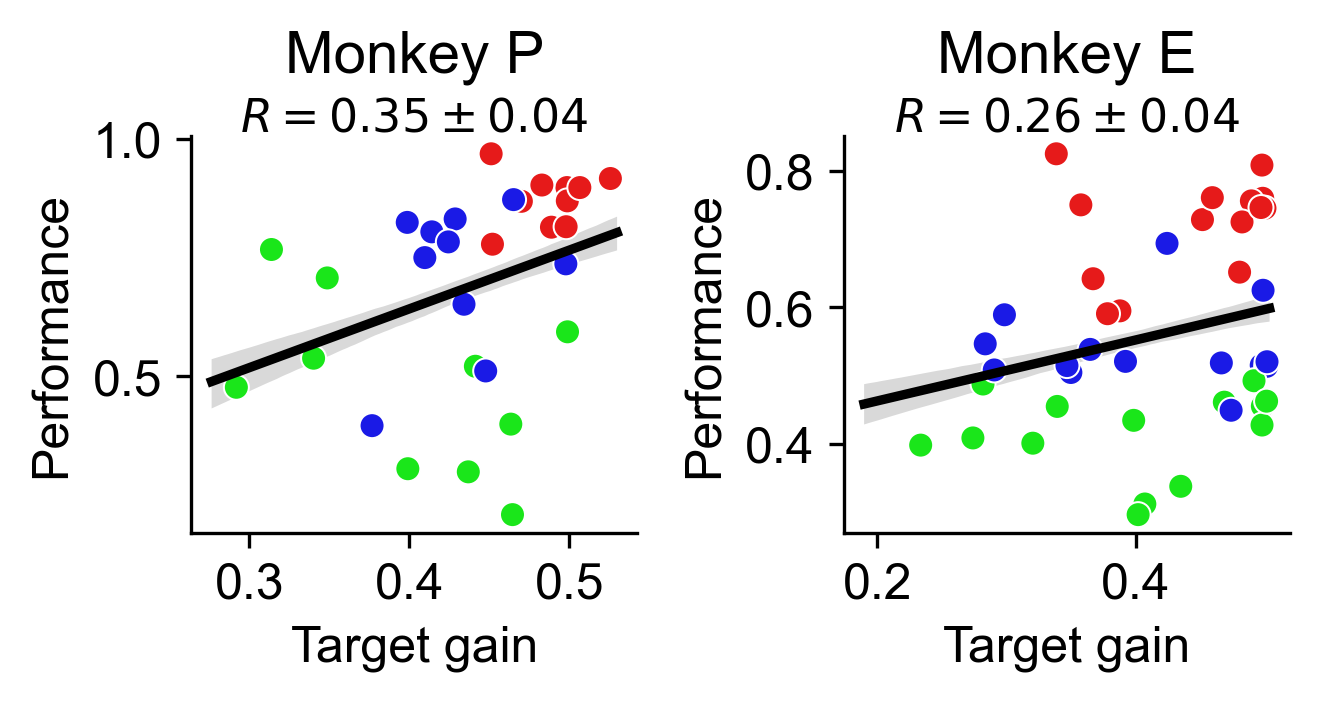

In [4]:
"""Performance plot."""

PALETTE = {
    0: (0.9, 0.1, 0.1),
    1: (0.1, 0.9, 0.1),
    2: (0.1, 0.1, 0.9),
}

# Plot
fig, axes = plt.subplots(1, 2, figsize=(4.5, 2.5))
for ax, subject in zip(axes, ["Perle", "Elgar"]):
    df_subject = df_attn_performance[df_attn_performance["subject"] == subject]
    agg = {
        "Target attention": "mean",
        "Performance": "mean",
        "Residual target attention": "mean",
        "Residual performance": "mean",
    }

    # Compute average per session
    df_subject_average_per_session = df_subject.groupby(
        ["subject", "session", "num_objects", "Target location"]
    ).agg(agg).reset_index()

    # Compute average per session seed
    df_subject_average_per_session_seed = df_subject.groupby(
        ["subject", "session", "seed", "num_objects", "Target location"]
    ).agg(agg).reset_index()

    # Compute average per seed
    df_subject_average_per_seed = df_subject.groupby(
        ["subject", "session", "seed", "num_objects", "Target location"]
    ).agg(agg).reset_index()

    # Compute average per trial
    df_subject_average_per_trial = df_subject.groupby(
        ["subject", "session", "trial_num", "num_objects", "Target location"]
    ).agg(agg).reset_index()

    # Plot regression line
    sns.regplot(
        ax=ax,
        data=df_subject_average_per_session_seed,
        x="Target attention",
        y="Performance",
        scatter=False,
        color='k',
    )

    # Plot mean points
    sns.scatterplot(
        data=df_subject_average_per_session,
        x="Target attention",
        y="Performance",
        ax=ax,
        hue="Target location",
        legend=False,
        palette=PALETTE,
    )

    # Compute correlation statistics
    num_points = len(df_subject_average_per_session_seed)
    x_vals = df_subject_average_per_session_seed["Performance"].values
    y_vals = df_subject_average_per_session_seed["Target attention"].values
    corr = pearsonr(x_vals, y_vals)[0]
    p_value = pearsonr(x_vals, y_vals)[1]
    n_bootstrap = 1000
    bootstrap_corrs = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(np.arange(len(x_vals)), size=len(x_vals), replace=True)
        bootstrap_corrs.append(np.corrcoef(x_vals[indices], y_vals[indices])[0, 1])
    bootstrap_corrs = np.array(bootstrap_corrs)
    corr_sem = np.std(bootstrap_corrs)
    print(f"Subject: {subject}, R = {corr:8f}, corr_sem: {corr_sem}, p-value: {p_value}, num_points: {num_points}")
    
    # Add correlation text
    ax.text(
        0.5, 1.1,
        f"$R={corr:.2f} \pm {corr_sem:.2f}$",
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment='top',
        horizontalalignment='center',
    )

    # Plot settings
    sns.despine(ax=ax)
    ax.set_title(f"Monkey {subject[0]}", y=1.1)
    if MODEL_NAME == "triangle_gain":
        ax.set_xlabel("Target gain")
    else:
        ax.set_xlabel("Target attention")

    # Set x-axis limits if triangle_slot_partition
    if MODEL_NAME == "triangle_slot_partition":
        ax.set_xlim(0.4, 0.9)

# Save figure
fig.tight_layout()
WRITE_DIR.mkdir(parents=True, exist_ok=True)
write_path = WRITE_DIR / f"performance_{MODEL_NAME}.pdf"
fig.savefig(write_path, bbox_inches="tight", pad_inches=0.01)

<>:87: SyntaxWarning: invalid escape sequence '\p'
<>:87: SyntaxWarning: invalid escape sequence '\p'
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_8686/570221204.py:87: SyntaxWarning: invalid escape sequence '\p'
  f"$R={corr:.2f}$\n   $\pm {corr_sem:.2f}$",
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/scipy/stats/_stats_py.py:4776: RuntimeWarning: overflow encountered in vecdot
  r = xp.vecdot(xm / normxm, ym / normym, axis=axis)


Subject: Perle, R = -0.139301, corr_sem: 0.016234948594535815, p-value: 1.3874578695342006e-17


/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/opt/miniconda3/envs/wm_paper/lib/python3.12/site-packages/scipy/stats/_stats_py.py:4776: RuntimeWarning: overflow encountered in vecdot
  r = xp.vecdot(xm / normxm, ym / normym, axis=axis)


Subject: Elgar, R = -0.038747, corr_sem: 0.014615638950243353, p-value: 0.00679315838388408


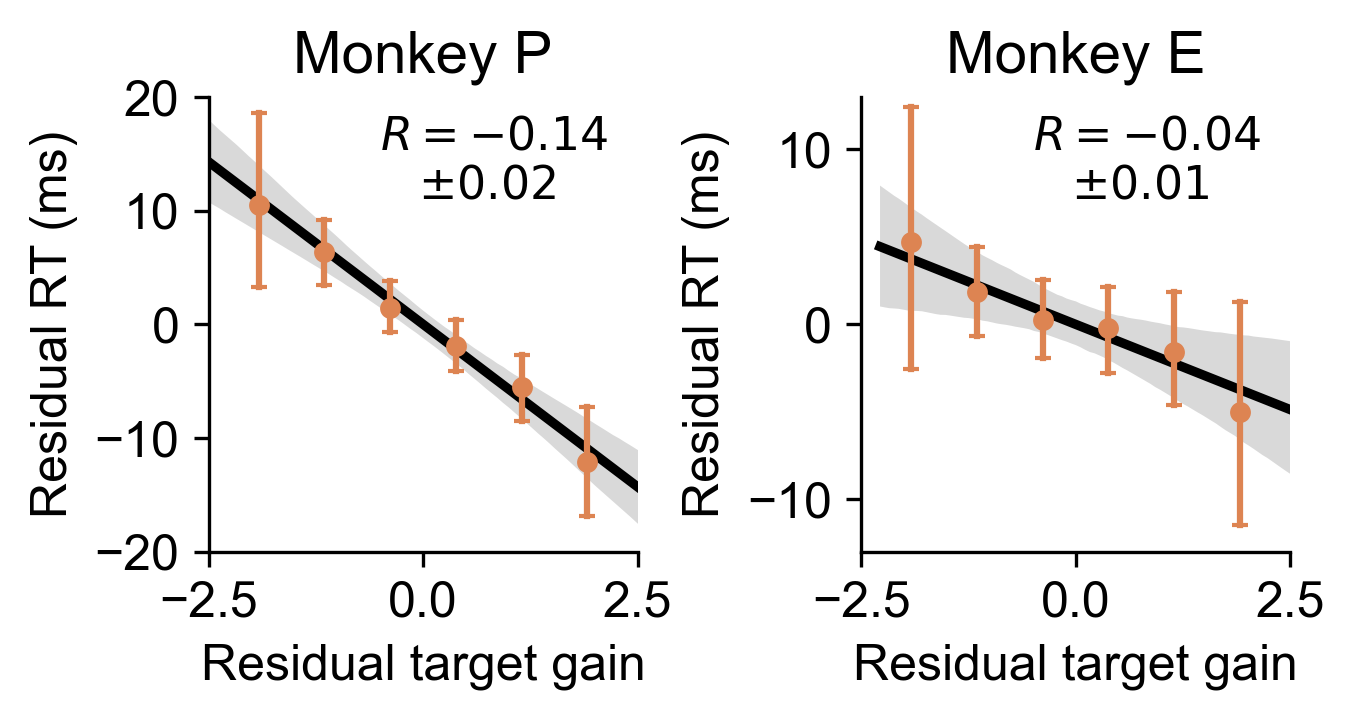

In [5]:
"""Reaction time plot."""

# Plot
fig, axes = plt.subplots(1, 2, figsize=(4.5, 2.5))
for ax, subject in zip(axes, ["Perle", "Elgar"]):
    df_subject = df_attn_reaction_time[df_attn_reaction_time["subject"] == subject]
    agg = {
        "Target attention": "mean",
        "Reaction time": "mean",
        "Residual target attention": "mean",
        "Residual reaction time": "mean",
    }

    # Compute average per session
    df_subject_average_per_session = df_subject.groupby(
        ["subject", "session", "num_objects", "Target location"]
    ).agg(agg).reset_index()

    # Compute average per seed
    df_subject_average_per_seed = df_subject.groupby(
        ["subject", "session", "seed", "num_objects", "Target location"]
    ).agg(agg).reset_index()

    # Compute average per trial
    df_subject_average_per_trial = df_subject.groupby(
        ["subject", "session", "trial_num", "num_objects", "Target location"]
    ).agg(agg).reset_index()

    # Bin attention residual
    bin_edges = np.linspace(-2.3, 2.3, 7)
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    df_subject_average_per_trial["Residual target attention binned"] = pd.cut(
        df_subject_average_per_trial["Residual target attention"],
        bins=bin_edges,
        labels=bin_centers,
    )

    # Plot regression line
    sns.regplot(
        ax=ax,
        data=df_subject_average_per_trial,
        x="Residual target attention",
        y="Residual reaction time",
        scatter=False,
        color='k',
    )

    # Scatter reaction time residual for each attention bin
    sns.lineplot(
        data=df_subject_average_per_trial,
        ax=ax,
        x="Residual target attention binned",
        y="Residual reaction time",
        color=sns.color_palette("deep")[1],
        alpha=1,
        size=10,
        legend=False,
        marker='o',
        markeredgecolor='none',
        markersize=5,
        linestyle='',
        err_style='bars',
        err_kws=dict(capsize=2),
    )

    # Compute correlation statistics
    x_vals = df_subject_average_per_trial["Residual target attention"].values
    y_vals = df_subject_average_per_trial["Residual reaction time"].values
    finite_mask = np.isfinite(x_vals) & np.isfinite(y_vals)
    x_vals = x_vals[finite_mask]
    y_vals = y_vals[finite_mask]
    num_points = len(df_subject_average_per_trial)
    corr = pearsonr(x_vals, y_vals)[0]
    p_value = pearsonr(x_vals, y_vals)[1]
    n_bootstrap = 1000
    bootstrap_corrs = []
    for _ in range(n_bootstrap):
        indices = np.random.choice(np.arange(len(x_vals)), size=len(x_vals), replace=True)
        bootstrap_corrs.append(np.corrcoef(x_vals[indices], y_vals[indices])[0, 1])
    bootstrap_corrs = np.array(bootstrap_corrs)
    corr_sem = np.std(bootstrap_corrs)
    print(f"Subject: {subject}, R = {corr:8f}, corr_sem: {corr_sem}, p-value: {p_value}")
    
    # Add correlation text
    ax.text(
        0.4, 0.96,
        f"$R={corr:.2f}$\n   $\pm {corr_sem:.2f}$",
        transform=ax.transAxes,
        fontsize=11,
        verticalalignment='top',
        horizontalalignment='left',
    )

    # Plot settings
    sns.despine(ax=ax)
    ax.set_title(f"Monkey {subject[0]}")
    ax.set_xlim([-2.5, 2.5])
    if MODEL_NAME == "triangle_gain":
        ax.set_xlabel("Residual target gain")
    else:
        ax.set_xlabel("Residual target attn")
    ax.set_ylabel("Residual RT (ms)")
    if MODEL_NAME == "triangle_gain":
        if subject == "Perle":
            ax.set_ylim([-20, 20])
        else:
            ax.set_ylim([-13, 13])
    elif MODEL_NAME == "triangle_switching":
        if subject == "Perle":
            ax.set_ylim([-15, 15])
        else:
            ax.set_ylim([-18, 18])
    elif MODEL_NAME == "triangle_slot_partition":
        if subject == "Perle":
            ax.set_ylim([-25, 25])
        else:
            ax.set_ylim([-15, 15])
            ax.set_xlim([-2.5, 1.9])

# Save figure
fig.tight_layout()
WRITE_DIR.mkdir(parents=True, exist_ok=True)
write_path = WRITE_DIR / f"reaction_time_{MODEL_NAME}.pdf"
fig.savefig(write_path, bbox_inches="tight", pad_inches=0.01)

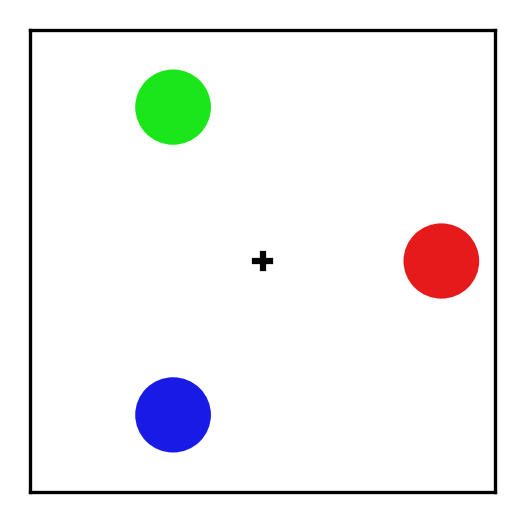

In [6]:
"""Plot performance colorscheme."""

# Plot triangle with same colors
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.set_xticks([])
ax.set_yticks([])
for i in range(3):
    color = PALETTE[i]
    theta = 2 * np.pi / 3 * i
    x = np.cos(theta)
    y = np.sin(theta)
    circle = plt.Circle((x, y), 0.2, color=color, fill=True)
    ax.add_artist(circle)
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)

# Make fixation cross
ax.plot([0, 0], [-0.04, 0.04], color="black")
ax.plot([-0.04, 0.04], [0, 0], color="black")

# Save figure
colorscheme_path = WRITE_DIR / "performance_colorscheme.pdf"
fig.savefig(colorscheme_path, bbox_inches="tight", pad_inches=0.01)